# SHAP INTERPRETETION

# LG REG

Loaded model expects 95041 features.
X_train.pkl not found. Creating dummy X_train.
Using X_train of shape: (100, 95041)
Background data shape: (30, 95041)
Using SHAP LinearExplainer for logistic regression.


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Explaining on data shape: (50, 95041)
SHAP value calculation complete.
Generating summary plot...


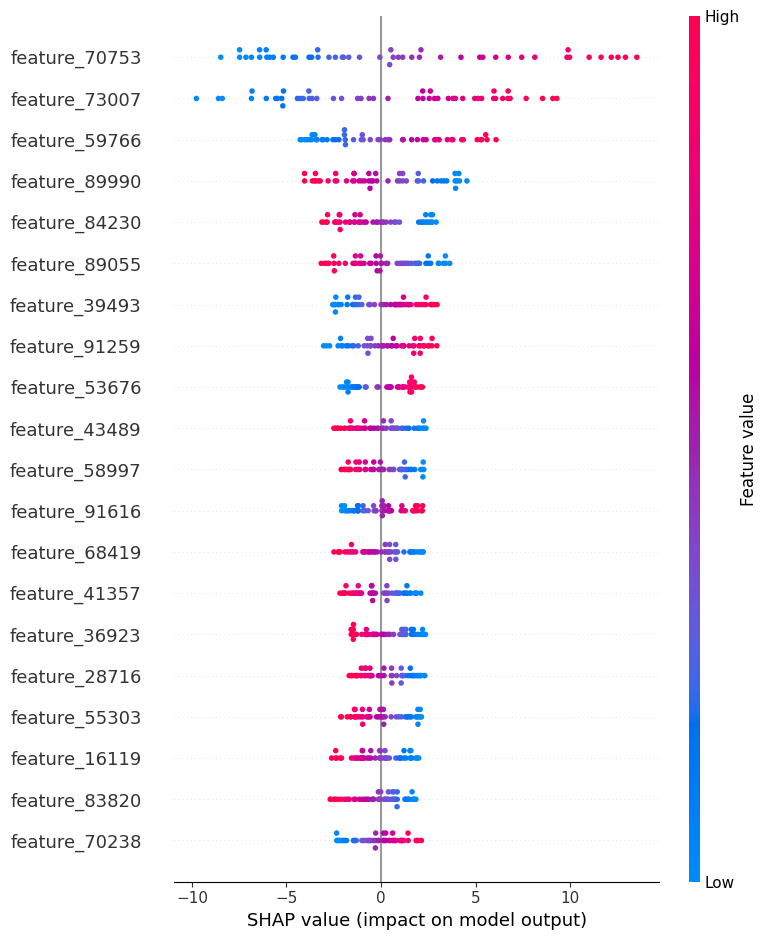

SHAP summary plot generated.


In [ ]:
import shap
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load the model
with open('/content/fake_news_models.pkl', 'rb') as f:
    model_dict = pickle.load(f)

model = model_dict.get('LR_model')
if model is None:
    raise KeyError("The key 'LR_model' was not found in the pickled dictionary.")

expected_num_features = model.n_features_in_
print(f"Loaded model expects {expected_num_features} features.")

# Load training data or generate dummy
try:
    with open('/content/drive/My Drive/X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)

    if X_train.shape[1] != expected_num_features:
        print(f"Warning: X_train has {X_train.shape[1]} features; model expects {expected_num_features}")

except FileNotFoundError:
    print("X_train.pkl not found. Creating dummy X_train.")
    X_train = pd.DataFrame(np.random.rand(100, expected_num_features),
                           columns=[f'feature_{i}' for i in range(expected_num_features)])

print(f"Using X_train of shape: {X_train.shape}")

# Sample background data
background_data = X_train.sample(n=min(30, len(X_train)), random_state=42)
print(f"Background data shape: {background_data.shape}")

# Use LinearExplainer if possible (much faster for Logistic Regression)
try:
    explainer = shap.LinearExplainer(model, background_data, feature_perturbation="interventional")
    print("Using SHAP LinearExplainer for logistic regression.")
except Exception as e:
    print("Falling back to KernelExplainer due to:", str(e))
    explainer = shap.KernelExplainer(model.predict_proba, background_data, model_output='probability')

# Limit SHAP computation to a small sample
sample_to_explain = X_train.sample(n=min(50, len(X_train)), random_state=42)
print(f"Explaining on data shape: {sample_to_explain.shape}")

try:
    shap_values = explainer.shap_values(sample_to_explain)
    print("SHAP value calculation complete.")
except Exception as e:
    print("Error computing SHAP values:", str(e))
    shap_values = None

# Plot if values computed
if shap_values is not None:
    print("Generating summary plot...")
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap.summary_plot(shap_values[1], sample_to_explain)
    else:
        shap.summary_plot(shap_values, sample_to_explain)
    print("SHAP summary plot generated.")
else:
    print("Could not generate SHAP plot due to previous error.")


# XG BOST

Keys available in model_dict: dict_keys(['LR_model', 'DT_model', 'GB_model', 'RF_model', 'tfidf_vectorizer'])
XGB_model not found. Checking for 'GB_model' as a fallback.
Loaded 'GB_model' as a fallback.
Loaded model expects 95041 features.
X_train.pkl not found. Creating dummy X_train.
Using X_train of shape: (100, 95041)
Background data shape: (30, 95041)
Using SHAP TreeExplainer.
Explaining on data shape: (50, 95041)
SHAP value calculation complete.
Generating summary plot...


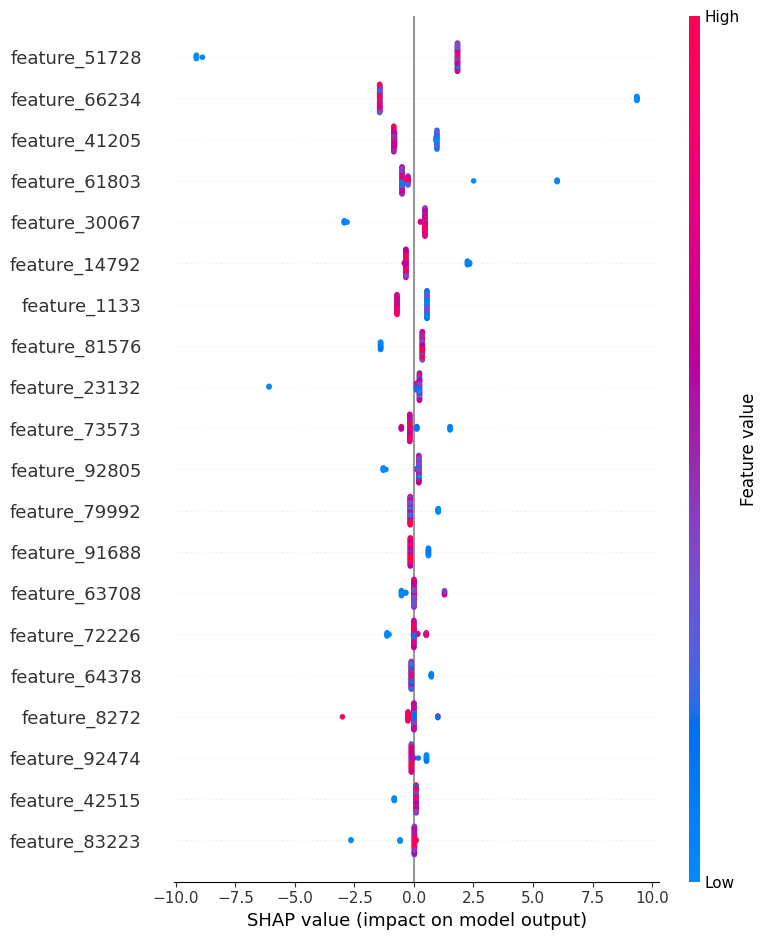

SHAP summary plot generated.


In [ ]:
import shap
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb  # Required if the model is an XGBoost Booster
# Import GradientBoostingClassifier if 'GB_model' is used as a fallback
from sklearn.ensemble import GradientBoostingClassifier

# === Load XGB model from dictionary ===
with open('/content/fake_news_models.pkl', 'rb') as f:
    model_dict = pickle.load(f)

# Print the keys in the dictionary to identify the correct key
print("Keys available in model_dict:", model_dict.keys())

# Try to get the XGBoost model first
model = model_dict.get('XGB_model')

if model is None:
    # If XGB_model is not found, check if a similar model like Gradient Boosting is available
    print("XGB_model not found. Checking for 'GB_model' as a fallback.")
    model = model_dict.get('GB_model') # Try to load the Gradient Boosting model

    if model is None:
        # If neither is found, raise an informative error
        raise KeyError(f"Neither 'XGB_model' nor 'GB_model' was found in the pickled dictionary. Available keys are: {model_dict.keys()}")
    else:
        print("Loaded 'GB_model' as a fallback.")
        # Note: If you load 'GB_model', TreeExplainer is still appropriate.
else:
    print("Loaded 'XGB_model'.")


# Proceed with the rest of the code
# Check if the loaded model has the n_features_in_ attribute
# This attribute is standard for scikit-learn and XGBoost models from recent versions
if hasattr(model, 'n_features_in_'):
    expected_num_features = model.n_features_in_
    print(f"Loaded model expects {expected_num_features} features.")
else:
    # If the attribute is not present, you might need to infer the number of features
    # from the training data when it's loaded, or assume the original training shape.
    # This is a less reliable fallback. Let's assume X_train will match eventually.
    print("Warning: Loaded model does not have 'n_features_in_'. Will rely on X_train shape.")
    expected_num_features = None # We'll check shape against X_train later if needed.


# === Load training data or fallback ===
try:
    with open('/content/drive/My Drive/X_train.pkl', 'rb') as f:
        X_train = pickle.load(f)

    # Check feature count only if the model had n_features_in_
    if expected_num_features is not None and X_train.shape[1] != expected_num_features:
        print(f"Warning: X_train has {X_train.shape[1]} features; model expects {expected_num_features}")
    elif expected_num_features is None:
         # If model didn't have n_features_in_, assume X_train shape is correct
         expected_num_features = X_train.shape[1]
         print(f"Model did not have n_features_in_. Assuming X_train has the correct number of features ({expected_num_features}).")


except FileNotFoundError:
    print("X_train.pkl not found. Creating dummy X_train.")
    # If dummy data is created, we MUST have the expected number of features
    if expected_num_features is None:
         # If model didn't have n_features_in_ AND X_train.pkl is missing,
         # we can't determine the feature count. This is a critical error.
         raise FileNotFoundError("Cannot determine expected number of features. X_train.pkl is missing and model lacks 'n_features_in_'.")

    X_train = pd.DataFrame(np.random.rand(100, expected_num_features),
                           columns=[f'feature_{i}' for i in range(expected_num_features)])

print(f"Using X_train of shape: {X_train.shape}")

# === Sample background data ===
background_data = X_train.sample(n=min(30, len(X_train)), random_state=42)
print(f"Background data shape: {background_data.shape}")

# === Use TreeExplainer (best for tree-based models like XGBoost or Gradient Boosting) ===
try:
    # Use TreeExplainer for either XGBoost or scikit-learn Gradient Boosting
    explainer = shap.TreeExplainer(model, background_data)
    print("Using SHAP TreeExplainer.")
except Exception as e:
    print("Falling back to KernelExplainer due to:", str(e))
    # Fallback for models that don't work with TreeExplainer (less common for XGB/GB)
    # Use model.predict_proba for classification, model.predict for regression
    if hasattr(model, 'predict_proba'):
        explainer = shap.KernelExplainer(model.predict_proba, background_data, model_output='probability')
    elif hasattr(model, 'predict'):
         explainer = shap.KernelExplainer(model.predict, background_data)
    else:
         raise TypeError("Loaded model does not have 'predict_proba' or 'predict' methods for KernelExplainer.")


# === Explain a smaller subset to avoid runtime crash ===
sample_to_explain = X_train.sample(n=min(50, len(X_train)), random_state=42)
print(f"Explaining on data shape: {sample_to_explain.shape}")

# === Compute SHAP values ===
try:

    shap_values = explainer.shap_values(sample_to_explain)
    print("SHAP value calculation complete.")
except Exception as e:
    print("Error computing SHAP values:", str(e))
    shap_values = None

# === Plot SHAP values ===
if shap_values is not None:
    print("Generating summary plot...")
    # Check if shap_values is a list (for multi-output or probability explainers)
    if isinstance(shap_values, list) and len(shap_values) > 0:
         # Assuming binary classification, plot for the positive class (index 1)
         # Check if index 1 is valid
         if len(shap_values) > 1:
              shap.summary_plot(shap_values[1], sample_to_explain, feature_names=sample_to_explain.columns)
              print("SHAP summary plot generated for class 1.")
         else:
              # If it's a list but only one element (e.g., regression or single class)
              shap.summary_plot(shap_values[0], sample_to_explain, feature_names=sample_to_explain.columns)
              print("SHAP summary plot generated for the first class/output.")
    else:
        # If shap_values is a numpy array (e.g., regression with direct predict)
        shap.summary_plot(shap_values, sample_to_explain, feature_names=sample_to_explain.columns)
        print("SHAP summary plot generated.")
else:
    print("Could not generate SHAP plot due to previous error.")